# **Imports**

Files will need to be imported locally.

In [0]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, preprocessing
from sklearn.model_selection import GridSearchCV
from google.colab import files
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.model_selection import learning_curve
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import ShuffleSplit
from sklearn.decomposition import FastICA
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import savefig

#Mounting Google Drive
#from google.colab import drive
#drive.mount('/content/gdrive')

#Importing csv files
trainingData = pd.read_csv('training.csv')
testingData = pd.read_csv('testing.csv')
additionalData = pd.read_csv('additional_training.csv')
annotation_confidence = pd.read_csv('annotation_confidence.csv')

# **Formatting Data**

*   Replaces NaN values with the mean
*   Concatenate training data and additional training data
*   Formatting the data correctly for pre-processing



In [0]:
#Replacing additional training data NaN values to the mean of additional data
trainNaN = additionalData.fillna(additionalData.mean())

#Concatenate training data and additional training data
allTrainingData = pd.concat([trainingData, trainNaN])

#Converting combined training data into a matrix
data_matrix = allTrainingData.values

#Generating X by removing ID and prediction columns
X = data_matrix[:,1:-1]

#Generating y by removing all but prediction values
y = data_matrix[:,-1:]

#Converting testing data into a matrix and removing ID column
testingData_matrix = testingData.values
testingData_matrix = testingData_matrix[:,1:]

#Converting annotation confidence into a matrix and removing ID column
annotation_confidence_matrix = annotation_confidence.values
annotation_confidence_matrix = annotation_confidence_matrix[:,-1:]

# **Preprocessing**


*   Feature Scaling using Min Max Scaler
*   Undersampling training data to balance classes
*   Data transformation on X resampled using FastICA



In [0]:
#Scaling
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X)
testing_minmax = min_max_scaler.transform(testingData_matrix)

In [64]:
#undersampling
print('Original dataset len %s' % len(y))
print('Original dataset shape %s' % Counter(y.ravel()))
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train_minmax, y.ravel())
print('Resampled dataset shape %s' % Counter(y_res.ravel()))
print('Resampled dataset len %s' % len(y_res))
confidence = []
for index in rus.sample_indices_:
  confidence.append(annotation_confidence_matrix[index])
confidence_values = np.asarray(confidence, dtype=np.float32)

Original dataset len 2590
Original dataset shape Counter({1.0: 1555, 0.0: 1035})
Resampled dataset shape Counter({0.0: 1035, 1.0: 1035})
Resampled dataset len 2070


In [0]:
#ICA
transformer = FastICA(n_components=120, random_state=42)
X_transformed = transformer.fit_transform(X_res)
testFeaturesICA = transformer.transform(testing_minmax)

# **Classification and Prediction**


*   Building the SVM using optimised hyperparameters from grid search
*   Fitting the SVM with X ICA transformed, y resampled and confidence values for sample weights
*   Predicting the testing data using ICA transformed testing data
*   Casting prediction values to int for Kaggle



In [0]:
#Building, training and predicting the classifier
clf = svm.SVC(kernel='rbf', C=5.052631578947368, gamma=0.7526315789473685)
clf.fit(X_transformed, y_res.ravel(), sample_weight=confidence_values.ravel())
predictions = clf.predict(testFeaturesICA)
prediction = []
for predict in predictions:
  prediction.append(int(predict))

# **Cross Validation**

*   Calculating k fold cross validation scores (where k_folds = 10)
*   Displaying the mean of the cross validation scores for each k fold



In [67]:
#Cross Validation Score
score = cross_val_score(clf, X_transformed, y_res.ravel(), cv = 10)
print('CV mean score',mean(score))

CV mean score 0.7091719566840926


# **Plotting Learning Curve**

Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# **Display Learning Curve**


*   Plotting and displaying learning curve for SVM
*   Downloading learning curve as a PNG (commented out for grading)



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

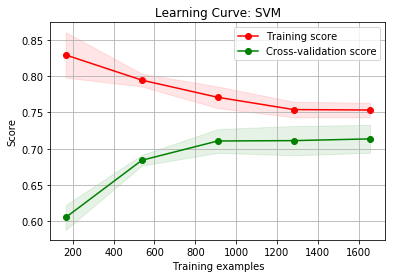

In [68]:
#Plot Learning Curve
title = 'Learning Curve: SVM'
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(clf, title, X_transformed, y_res, cv=cv, n_jobs=-1)
#plt.savefig("LearningCurve.png")
#files.download("LearningCurve.png")

# **Exporting to CSV**



*   Exporting prediction results to CSV for Kaggle submission



In [0]:
#exporting to csv
submission = pd.DataFrame({"prediction":prediction})
submission.index = np.arange(1, len(submission) + 1)
submission.index.name = "ID"
submission.to_csv("submission.csv")

#downloads csv file
files.download("submission.csv")

# **Gridsearch for SVM to Optimise Hyperparameters**



*   Optimised grid search to get accurate hyperparameters



In [19]:
parameters = {'kernel':('linear', 'rbf'), 'C':np.linspace(1,10, num = 10), 'gamma':np.linspace(0.1,5,num=10)}
grid_search = GridSearchCV(svm.SVC(), parameters, cv=5,  n_jobs=-1, verbose = 2)
grid_search.fit(X_transformed, y_res.ravel())
print(grid_search.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  9.2min finished


{'C': 6.0, 'gamma': 0.6444444444444445, 'kernel': 'rbf'}


In [22]:
parameters = {'C':np.linspace(5,7, num = 20), 'gamma':np.linspace(0.1,1,num=20)}
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), parameters, cv=5,  n_jobs=-1, verbose = 2)
grid_search.fit(X_transformed, y_res.ravel())
print(grid_search.best_params_)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 20.3min finished


{'C': 5.0, 'gamma': 0.7631578947368421}


In [23]:
parameters = {'C':np.linspace(5,6, num = 20), 'gamma':np.linspace(0.5,0.8,num=20)}
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), parameters, cv=5,  n_jobs=-1, verbose = 2)
grid_search.fit(X_transformed, y_res.ravel())
print(grid_search.best_params_)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 19.6min finished


{'C': 5.052631578947368, 'gamma': 0.7526315789473685}
